# TASK 5.2

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%tensorflow_version 2.x
import os
import itertools
import csv
import numpy as np
import tensorflow as tf
import random as rn
from sklearn.utils import class_weight
from sklearn.calibration import CalibratedClassifierCV
from sklearn import preprocessing
from sklearn.metrics import fbeta_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import joblib
from sklearn.svm import LinearSVC, SVC
from skimage import exposure
from tensorflow.compat.v1.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers
from numpy import dstack
from sklearn.linear_model import LogisticRegression
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Parameters
DIR_PATH = '/content/drive/Shareddrives/Verna_Minutella_Veltroni'
MODEL_PATH = os.path.join(DIR_PATH, 'models/models_task5_2') 
NUMPY_PATH = os.path.join(DIR_PATH, 'numpy_data')

BATCH_SIZE = 64


# Set seed for reproducibility
tf.keras.backend.clear_session()

seed_num = 1
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed_num)
rn.seed(seed_num)
tf.random.set_seed(seed_num)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

## Utility function

### Loading training and test set

In [3]:
# Loading training and test set
def load_train():
  images = np.load(os.path.join(NUMPY_PATH,'train_tensor.npy'))
  labels = np.load(os.path.join(NUMPY_PATH,'train_labels.npy'))
  return images, labels

def load_test():
  images = np.load(os.path.join(NUMPY_PATH,'public_test_tensor.npy'))
  labels = np.load(os.path.join(NUMPY_PATH,'public_test_labels.npy'))
  return images, labels

### Plotting the confusion matrix

In [4]:
# function to print the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    print('Specificity : ', specificity )

    sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
    print('Sensitivity : ', sensitivity)
    plt.show()

### Plotting the ROC curve

In [5]:
def plot_roc_curve(probs, test_labels):
    f = fbeta_score(test_labels, np.rint(probs), beta=2.0)
    print('Result: f2_score=%.3f' % (f))

    fpr, tpr, threshold = roc_curve(test_labels, probs)
    roc_auc = auc(fpr, tpr) 
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Plotting accuracy and loss trends

In [12]:
def performance_plot(history, model):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  fig1 = plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

### Setting the seed

In [6]:
# function to set the seed before each execution of the model
def set_seed():
    tf.keras.backend.clear_session()

    seed_num = 1
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(seed_num)
    rn.seed(seed_num)
    tf.random.set_seed(seed_num)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    K.set_session(sess)

## Dataset creation

In [7]:
train_img, train_lab = load_train()
test_img, test_lab = load_test()


In [8]:
# TRAINING SET
abnormality_images = train_img[1::2] 
abnormality_labels = train_lab[1::2]

abnormality_images = abnormality_images.reshape((2676, 150, 150, 1)) 
abnormality_images = abnormality_images.astype('float32') / 65535

# benign
abnormality_labels[abnormality_labels == 1] = 0
abnormality_labels[abnormality_labels == 3] = 0
# malignant
abnormality_labels[abnormality_labels == 2] = 1
abnormality_labels[abnormality_labels == 4] = 1

# VALIDATION SET
train_images, valid_images, train_labels, valid_labels = train_test_split(abnormality_images, abnormality_labels, test_size=0.30, random_state=42, stratify=abnormality_labels)

# TEST SET
test_images = test_img[1::2]
test_labels = test_lab[1::2]

test_images = test_images.reshape((336, 150, 150, 1))
test_images = test_images.astype('float32')  / 65535 

# benign
test_labels[test_labels == 1] = 0
test_labels[test_labels == 3] = 0
# malignant
test_labels[test_labels == 2] = 1
test_labels[test_labels == 4] = 1


## Loading the best models

In [9]:
model1 = models.load_model(os.path.join(DIR_PATH, 'models/models_task2_2/model7_best.h5'))
#result = model1.evaluate(test_images, test_labels, batch_size=64)
#print(result)

model2 = models.load_model(os.path.join(DIR_PATH, 'models/models_task2_2/model6_best.h5'))
#result = model2.evaluate(test_images, test_labels, batch_size=64)
#print(result)


## Ensemble with models from scratch

### Logistic Regression

Stacked Train Accuracy: 0.682
Stacked Test Accuracy: 0.640
Specificity :  0.6164383561643836
Sensitivity :  0.6837606837606838


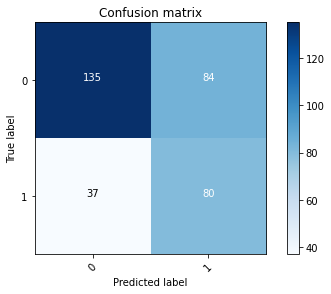

Result: f2_score=0.633


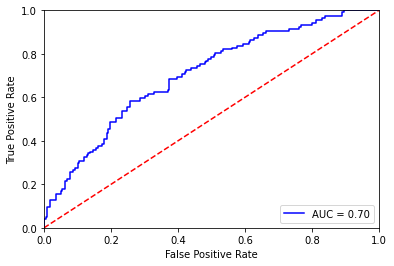

Stacked Valid Accuracy: 0.701
Specificity :  0.7070063694267515
Sensitivity :  0.6927710843373494


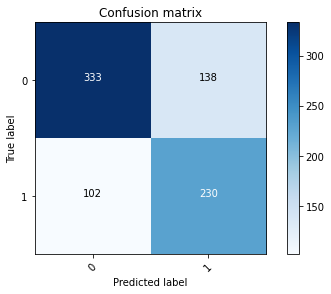

In [ ]:
# create stacked model input dataset as outputs from the ensemble
set_seed()

def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		pred = model.predict(inputX, verbose=0)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = pred
		else:
			stackX = dstack((stackX, pred))
	# flatten predictions to [rows, members x probabilities]
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # fit standalone model
    model = LogisticRegression(max_iter=500, random_state=13, class_weight='balanced')
    model.fit(stackedX, inputy)
    return model

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	pred = model.predict_proba(stackedX)[:,1]
	return pred

members=[model1,model2]

# fit stacked model using the ensemble
ensemble = fit_stacked_model(members, train_images, train_labels)

joblib.dump(ensemble, os.path.join(MODEL_PATH, 'logreg.h5'))

train_pred = stacked_prediction(members, ensemble, train_images)
train_acc = accuracy_score(train_labels, np.rint(train_pred))
print('Stacked Train Accuracy: %.3f' % train_acc)

# evaluate model on test set
test_pred = stacked_prediction(members, ensemble, test_images)
test_acc = accuracy_score(test_labels, np.rint(test_pred))
print('Stacked Test Accuracy: %.3f' % test_acc)

cm = confusion_matrix(test_labels, np.rint(test_pred))
plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')
plot_roc_curve(test_pred, test_labels)

valid_pred = stacked_prediction(members, ensemble, valid_images)
valid_acc = accuracy_score(valid_labels, np.rint(valid_pred))
print('Stacked Valid Accuracy: %.3f' % valid_acc)

cm_valid = confusion_matrix(valid_labels, np.rint(valid_pred))
plot_confusion_matrix(cm_valid, classes=[0,1], normalize=False, title='Confusion matrix')

### LinearSVC

Stacked Train Accuracy: 0.683
Stacked Test Accuracy: 0.676
Specificity :  0.726027397260274
Sensitivity :  0.5811965811965812


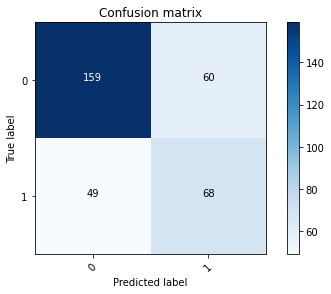

Result: f2_score=0.570


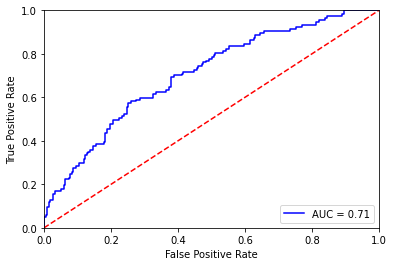

Stacked Valid Accuracy: 0.704
Specificity :  0.8046709129511678
Sensitivity :  0.5602409638554217


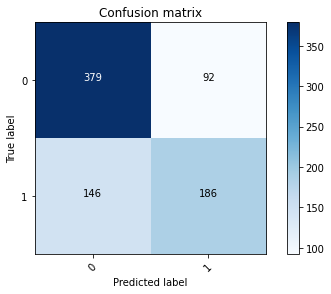

In [ ]:
set_seed()

def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		pred = model.predict(inputX)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = pred
		else:
			stackX = dstack((stackX, pred))
	# flatten predictions to [rows, members x probabilities]
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX

# fit a model based on the outputs from the ensemble2 members
def fit_stacked_model(members, inputX, inputy):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # fit standalone model
    model = CalibratedClassifierCV(base_estimator=LinearSVC(random_state=13, class_weight='balanced'))
    model.fit(stackedX, inputy)
    return model

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	pred = model.predict_proba(stackedX)[:,1]
	return pred

members=[model1,model2]

# fit stacked model using the ensemble
ensemble2 = fit_stacked_model(members, train_images, train_labels)

joblib.dump(ensemble2, os.path.join(MODEL_PATH, 'lsvc.h5'))

train_pred = stacked_prediction(members, ensemble2, train_images)
train_acc = accuracy_score(train_labels, np.rint(train_pred))
print('Stacked Train Accuracy: %.3f' % train_acc)

# evaluate model on test set
test_pred = stacked_prediction(members, ensemble2, test_images)
test_acc = accuracy_score(test_labels, np.rint(test_pred))
print('Stacked Test Accuracy: %.3f' % test_acc)

cm = confusion_matrix(test_labels, np.rint(test_pred))
plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')
plot_roc_curve(test_pred, test_labels)

valid_pred = stacked_prediction(members, ensemble2, valid_images)
valid_acc = accuracy_score(valid_labels, np.rint(valid_pred))
print('Stacked Valid Accuracy: %.3f' % valid_acc)

cm_valid = confusion_matrix(valid_labels, np.rint(valid_pred))
plot_confusion_matrix(cm_valid, classes=[0,1], normalize=False, title='Confusion matrix')

### SVC

Stacked Train Accuracy: 0.686
Stacked Test Accuracy: 0.628
Specificity :  0.6255707762557078
Sensitivity :  0.6324786324786325


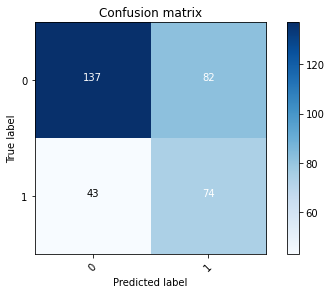

Result: f2_score=0.593


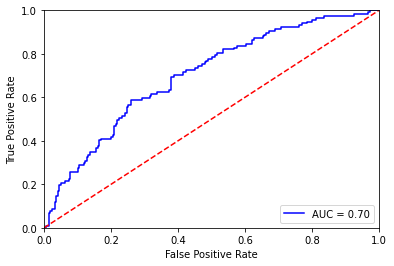

Stacked Valid Accuracy: 0.702
Specificity :  0.7346072186836518
Sensitivity :  0.6566265060240963


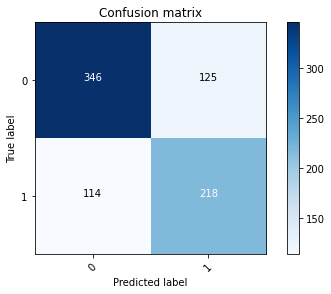

In [ ]:
set_seed()

def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		pred = model.predict(inputX, verbose=0)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = pred
		else:
			stackX = dstack((stackX, pred))
	# flatten predictions to [rows, members x probabilities]
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# fit standalone model
	model = SVC(probability=True, random_state=13, class_weight='balanced')
	model.fit(stackedX, inputy)
	return model

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	pred = model.predict_proba(stackedX)[:,1]
	return pred

members=[model1,model2]

# fit stacked model using the ensemble
ensemble3 = fit_stacked_model(members, train_images, train_labels)

joblib.dump(ensemble3, os.path.join(MODEL_PATH, 'svc.h5'))

train_pred = stacked_prediction(members, ensemble3, train_images)
train_acc = accuracy_score(train_labels, np.rint(train_pred))
print('Stacked Train Accuracy: %.3f' % train_acc)

# evaluate model on test set
test_pred = stacked_prediction(members, ensemble3, test_images)
test_acc = accuracy_score(test_labels, np.rint(test_pred))
print('Stacked Test Accuracy: %.3f' % test_acc)

cm = confusion_matrix(test_labels, np.rint(test_pred))
plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')
plot_roc_curve(test_pred, test_labels)

valid_pred = stacked_prediction(members, ensemble3, valid_images)
valid_acc = accuracy_score(valid_labels, np.rint(valid_pred))
print('Stacked Valid Accuracy: %.3f' % valid_acc)

cm_valid = confusion_matrix(valid_labels, np.rint(valid_pred))
plot_confusion_matrix(cm_valid, classes=[0,1], normalize=False, title='Confusion matrix')

## Ensemble with intermediate layers of model from scratch 

In [10]:
intermediate_layer_model1 = keras.Model(inputs=model1.input,
                                       outputs=model1.get_layer("dense").output)
intermediate_layer_model2 = keras.Model(inputs=model2.input,
                                       outputs=model2.get_layer("dense").output)

intermediate_layer_model1.save(os.path.join(MODEL_PATH, 'model7_layers.h5'))
intermediate_layer_model2.save(os.path.join(MODEL_PATH, 'model6_layers.h5'))


### Dense layer

Epoch 1/50
59/59 [==============================] - 1s 6ms/step - loss: 0.6601 - acc: 0.5921 - val_loss: 0.5701 - val_acc: 0.6837

Epoch 00001: val_loss improved from inf to 0.57009, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models/models_task5_2/model1_best.h5
Epoch 2/50
59/59 [==============================] - 0s 3ms/step - loss: 0.5913 - acc: 0.6704 - val_loss: 0.5559 - val_acc: 0.6999

Epoch 00002: val_loss improved from 0.57009 to 0.55586, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models/models_task5_2/model1_best.h5
Epoch 3/50
59/59 [==============================] - 0s 3ms/step - loss: 0.5844 - acc: 0.6692 - val_loss: 0.5535 - val_acc: 0.6999

Epoch 00003: val_loss improved from 0.55586 to 0.55351, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models/models_task5_2/model1_best.h5
Epoch 4/50
59/59 [==============================] - 0s 3ms/step - loss: 0.5819 - acc: 0.6662 - val_loss: 0.5561 - val_acc: 0.

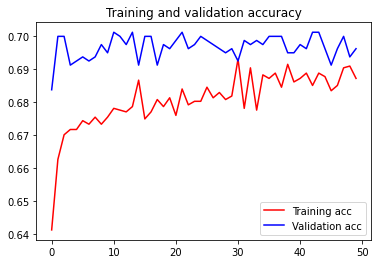

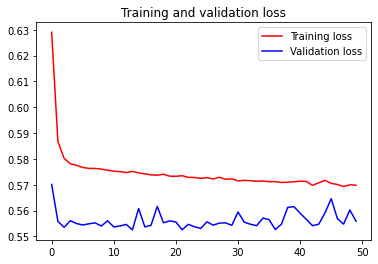

Stacked Train Accuracy: 0.686
Stacked Test Accuracy: 0.625
Specificity :  0.6027397260273972
Sensitivity :  0.6666666666666666


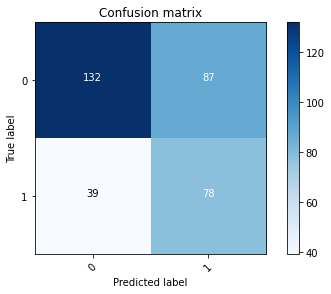

Result: f2_score=0.616


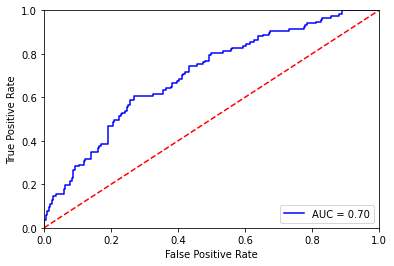

Stacked Valid Accuracy: 0.701
Specificity :  0.7112526539278131
Sensitivity :  0.6867469879518072


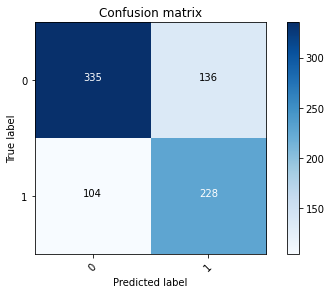

In [14]:
set_seed()

def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
      # make prediction
      pred = model.predict(inputX, verbose=0)
      if pred.shape[1] == 64:
        pred = np.hstack((pred, pred))
      # stack predictions into [rows, members, probabilities]
      if stackX is None:
        stackX = pred
      else:
        stackX = dstack((stackX, pred))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy, valid_images, valid_labels):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    stacked_valid = stacked_dataset(members, valid_images)
    # fit standalone model
    model = models.Sequential()
    model.add(layers.Dense(1, input_dim=256, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels)
    model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH, 'model1_best.h5'), monitor='val_loss', mode='min', verbose=1, save_best_only=True) #, save_weights_only=True)
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50)
    history = model.fit(stackedX, inputy, epochs=50, validation_data=(stacked_valid, valid_labels), callbacks = [callback, model_checkpoint], class_weight = dict(enumerate(class_weights)))
    
    performance_plot(history, model)
    return model

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	pred = model.predict(stackedX)
	return pred

members=[intermediate_layer_model1, intermediate_layer_model2]

# fit stacked model using the ensemble
model1 = fit_stacked_model(members, train_images, train_labels, valid_images, valid_labels)

model1.save(os.path.join(MODEL_PATH, 'model1.h5'))
best_model1 = models.load_model(os.path.join(MODEL_PATH, 'model1_best.h5'))

train_pred = stacked_prediction(members, best_model1, train_images)
train_acc = accuracy_score(train_labels, np.rint(train_pred))
print('Stacked Train Accuracy: %.3f' % train_acc)

# evaluate model1 on test set
test_pred = stacked_prediction(members, best_model1, test_images)
test_acc = accuracy_score(test_labels, np.rint(test_pred))
print('Stacked Test Accuracy: %.3f' % test_acc)

cm = confusion_matrix(test_labels, np.rint(test_pred))
plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')
plot_roc_curve(test_pred, test_labels)

valid_pred = stacked_prediction(members, best_model1, valid_images)
valid_acc = accuracy_score(valid_labels, np.rint(valid_pred))
print('Stacked Valid Accuracy: %.3f' % valid_acc)

cm_valid = confusion_matrix(valid_labels, np.rint(valid_pred))
plot_confusion_matrix(cm_valid, classes=[0,1], normalize=False, title='Confusion matrix')

### Dense layer and dropout

Epoch 1/50
59/59 [==============================] - 1s 6ms/step - loss: 0.6620 - acc: 0.5631 - val_loss: 0.5732 - val_acc: 0.6887

Epoch 00001: val_loss improved from inf to 0.57324, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models/models_task5_2/model2_best.h5
Epoch 2/50
59/59 [==============================] - 0s 3ms/step - loss: 0.5930 - acc: 0.6798 - val_loss: 0.5575 - val_acc: 0.6936

Epoch 00002: val_loss improved from 0.57324 to 0.55746, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models/models_task5_2/model2_best.h5
Epoch 3/50
59/59 [==============================] - 0s 3ms/step - loss: 0.5858 - acc: 0.6719 - val_loss: 0.5544 - val_acc: 0.6936

Epoch 00003: val_loss improved from 0.55746 to 0.55443, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models/models_task5_2/model2_best.h5
Epoch 4/50
59/59 [==============================] - 0s 3ms/step - loss: 0.5831 - acc: 0.6717 - val_loss: 0.5562 - val_acc: 0.

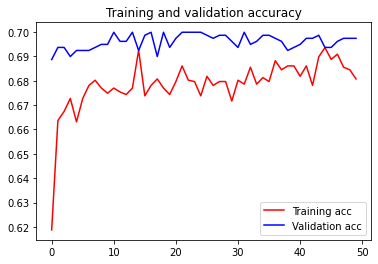

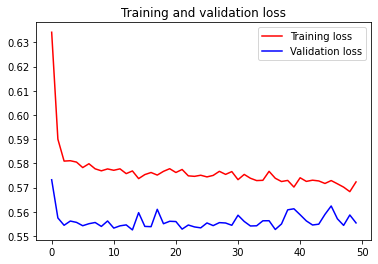

Stacked Train Accuracy: 0.682
Stacked Test Accuracy: 0.628
Specificity :  0.6027397260273972
Sensitivity :  0.6752136752136753


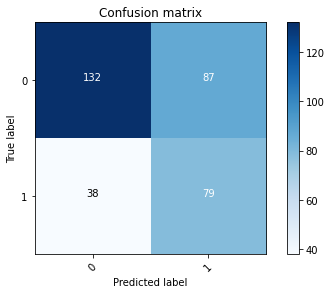

Result: f2_score=0.623


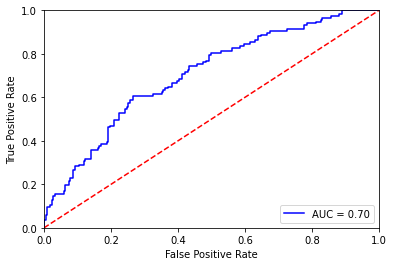

Stacked Valid Accuracy: 0.700
Specificity :  0.7112526539278131
Sensitivity :  0.6837349397590361


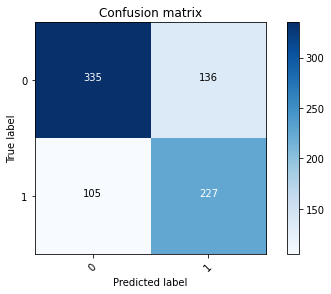

In [18]:
set_seed()

def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
      # make prediction
      pred = model.predict(inputX, verbose=0)
      if pred.shape[1] == 64:
        pred = np.hstack((pred, pred))
      # stack predictions into [rows, members, probabilities]
      if stackX is None:
        stackX = pred
      else:
        stackX = dstack((stackX, pred))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy, valid_images, valid_labels):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    stacked_valid = stacked_dataset(members, valid_images)
    # fit standalone model
    model = models.Sequential()
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels)
    model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH, 'model2_best.h5'), monitor='val_loss', mode='min', verbose=1, save_best_only=True) #, save_weights_only=True)
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50)
    history = model.fit(stackedX, inputy, epochs=50, validation_data=(stacked_valid, valid_labels), callbacks = [callback, model_checkpoint], class_weight = dict(enumerate(class_weights)))
    
    performance_plot(history, model)
    return model

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	pred = model.predict(stackedX)
	return pred

members=[intermediate_layer_model1, intermediate_layer_model2]

# fit stacked model using the ensemble
model2 = fit_stacked_model(members, train_images, train_labels, valid_images, valid_labels)

model2.save(os.path.join(MODEL_PATH, 'model2.h5'))
best_model2 = models.load_model(os.path.join(MODEL_PATH, 'model2_best.h5'))

train_pred = stacked_prediction(members, best_model2, train_images)
train_acc = accuracy_score(train_labels, np.rint(train_pred))
print('Stacked Train Accuracy: %.3f' % train_acc)
# evaluate model2 on test set
test_pred = stacked_prediction(members, best_model2, test_images)
test_acc = accuracy_score(test_labels, np.rint(test_pred))
print('Stacked Test Accuracy: %.3f' % test_acc)

cm = confusion_matrix(test_labels, np.rint(test_pred))
plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')
plot_roc_curve(test_pred, test_labels)

valid_pred = stacked_prediction(members, best_model2, valid_images)
valid_acc = accuracy_score(valid_labels, np.rint(valid_pred))
print('Stacked Valid Accuracy: %.3f' % valid_acc)

cm_valid = confusion_matrix(valid_labels, np.rint(valid_pred))
plot_confusion_matrix(cm_valid, classes=[0,1], normalize=False, title='Confusion matrix')

### Logistic Regression

Stacked Train Accuracy: 0.697
Stacked Test Accuracy: 0.637
Specificity :  0.6118721461187214
Sensitivity :  0.6837606837606838


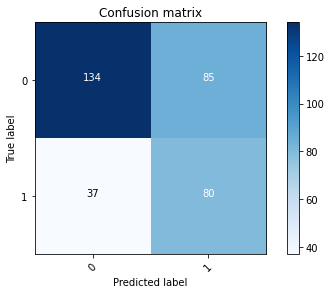

Result: f2_score=0.632


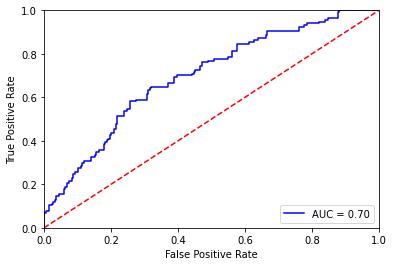

Stacked Valid Accuracy: 0.695
Specificity :  0.6942675159235668
Sensitivity :  0.6957831325301205


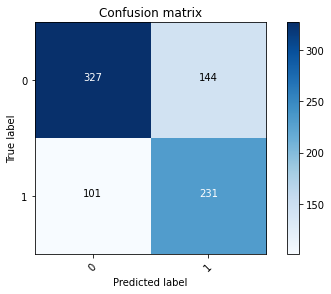

In [ ]:
set_seed()

def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
      # make prediction
      pred = model.predict(inputX, verbose=0)
      if pred.shape[1] == 64:
        pred = np.hstack((pred, pred))
      # stack predictions into [rows, members, probabilities]
      if stackX is None:
        stackX = pred
      else:
        stackX = dstack((stackX, pred))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # fit standalone model
    model = LogisticRegression(max_iter=500, random_state=13, class_weight='balanced')
    model.fit(stackedX, inputy)
    return model

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	pred = model.predict_proba(stackedX)[:,1]
	return pred

members=[intermediate_layer_model1, intermediate_layer_model2]

# fit stacked model using the ensemble
ensemble4 = fit_stacked_model(members, train_images, train_labels)

joblib.dump(ensemble4, os.path.join(MODEL_PATH, 'logreg_layers.h5'))

train_pred = stacked_prediction(members, ensemble4, train_images)
train_acc = accuracy_score(train_labels, np.rint(train_pred))
print('Stacked Train Accuracy: %.3f' % train_acc)

# evaluate ensemble4 on test set
test_pred = stacked_prediction(members, ensemble4, test_images)
acc = accuracy_score(test_labels, np.rint(test_pred))
print('Stacked Test Accuracy: %.3f' % acc)

cm = confusion_matrix(test_labels, np.rint(test_pred))
plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')
plot_roc_curve(test_pred, test_labels)

valid_pred = stacked_prediction(members, ensemble4, valid_images)
valid_acc = accuracy_score(valid_labels, np.rint(valid_pred))
print('Stacked Valid Accuracy: %.3f' % valid_acc)

cm_valid = confusion_matrix(valid_labels, np.rint(valid_pred))
plot_confusion_matrix(cm_valid, classes=[0,1], normalize=False, title='Confusion matrix')

### LinearSVC

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Stacked Train Accuracy: 0.711
Stacked Test Accuracy: 0.682
Specificity :  0.7625570776255708
Sensitivity :  0.5299145299145299


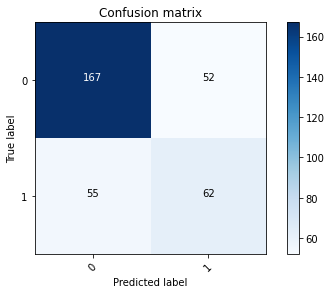

Result: f2_score=0.533


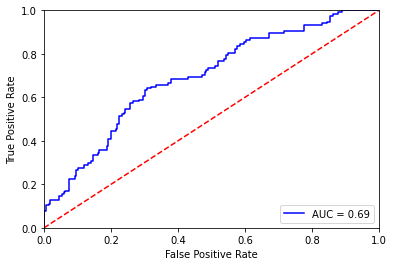

Stacked Valid Accuracy: 0.691
Specificity :  0.7983014861995754
Sensitivity :  0.5391566265060241


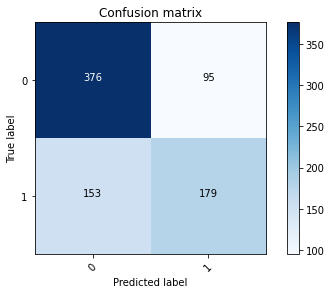

In [ ]:
set_seed()

def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
      # make prediction
      pred = model.predict(inputX, verbose=0)
      if pred.shape[1] == 64:
        pred = np.hstack((pred, pred))
      # stack predictions into [rows, members, probabilities]
      if stackX is None:
        stackX = pred
      else:
        stackX = dstack((stackX, pred))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# fit standalone model
	model = CalibratedClassifierCV(base_estimator=LinearSVC(max_iter=500, random_state=13, class_weight='balanced'))
	model.fit(stackedX, inputy)
	return model

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	pred = model.predict_proba(stackedX)[:,1]
	return pred

members=[intermediate_layer_model1, intermediate_layer_model2]

# fit stacked model using the ensemble
ensemble5 = fit_stacked_model(members, train_images, train_labels)

joblib.dump(ensemble5, os.path.join(MODEL_PATH, 'lsvc_layers.h5'))

train_pred = stacked_prediction(members, ensemble5, train_images)
train_acc = accuracy_score(train_labels, np.rint(train_pred))
print('Stacked Train Accuracy: %.3f' % train_acc)

# evaluate ensemble5 on test set
test_pred = stacked_prediction(members, ensemble5, test_images)
acc = accuracy_score(test_labels, np.rint(test_pred))
print('Stacked Test Accuracy: %.3f' % acc)

cm = confusion_matrix(test_labels, np.rint(test_pred))
plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')
plot_roc_curve(test_pred, test_labels)

valid_pred = stacked_prediction(members, ensemble5, valid_images)
valid_acc = accuracy_score(valid_labels, np.rint(valid_pred))
print('Stacked Valid Accuracy: %.3f' % valid_acc)

cm_valid = confusion_matrix(valid_labels, np.rint(valid_pred))
plot_confusion_matrix(cm_valid, classes=[0,1], normalize=False, title='Confusion matrix')

### SVC

Stacked Train Accuracy: 0.697
Stacked Test Accuracy: 0.652
Specificity :  0.684931506849315
Sensitivity :  0.5897435897435898


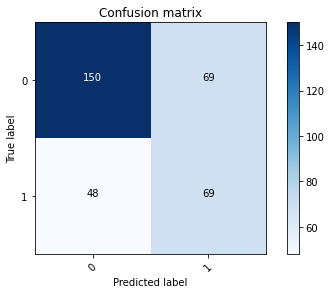

Result: f2_score=0.569


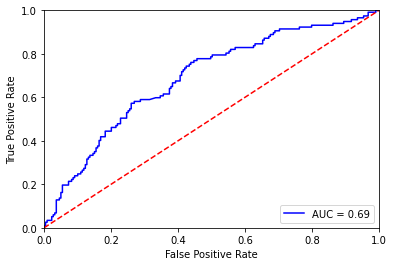

Stacked Valid Accuracy: 0.696
Specificity :  0.7600849256900213
Sensitivity :  0.6054216867469879


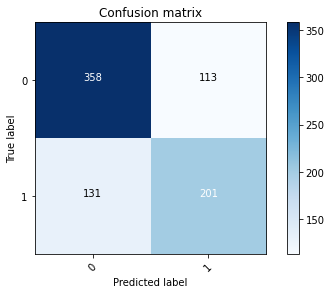

In [ ]:
set_seed()

def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
      # make prediction
      pred = model.predict(inputX, verbose=0)
      if pred.shape[1] == 64:
        pred = np.hstack((pred, pred))
      # stack predictions into [rows, members, probabilities]
      if stackX is None:
        stackX = pred
      else:
        stackX = dstack((stackX, pred))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # fit standalone model
    model = SVC(probability=True, random_state=13, class_weight='balanced')
    model.fit(stackedX, inputy)
    return model

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # make a prediction
    pred = model.predict_proba(stackedX)[:,1]
    return pred

members=[intermediate_layer_model1, intermediate_layer_model2]

# fit stacked model using the ensemble
ensemble6 = fit_stacked_model(members, train_images, train_labels)

joblib.dump(ensemble6, os.path.join(MODEL_PATH, 'svc_layers.h5'))

train_pred = stacked_prediction(members, ensemble6, train_images)
train_acc = accuracy_score(train_labels, np.rint(train_pred))
print('Stacked Train Accuracy: %.3f' % train_acc)

# evaluate ensemble6 on test set
test_pred = stacked_prediction(members, ensemble6, test_images)
acc = accuracy_score(test_labels, np.rint(test_pred))
print('Stacked Test Accuracy: %.3f' % acc)

cm = confusion_matrix(test_labels, np.rint(test_pred))
plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')
plot_roc_curve(test_pred, test_labels)

valid_pred = stacked_prediction(members, ensemble6, valid_images)
valid_acc = accuracy_score(valid_labels, np.rint(valid_pred))
print('Stacked Valid Accuracy: %.3f' % valid_acc)

cm_valid = confusion_matrix(valid_labels, np.rint(valid_pred))
plot_confusion_matrix(cm_valid, classes=[0,1], normalize=False, title='Confusion matrix')